#6. Class Activation Map 만들기

## 6.1) 데이터셋 준비하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir="/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data"
)

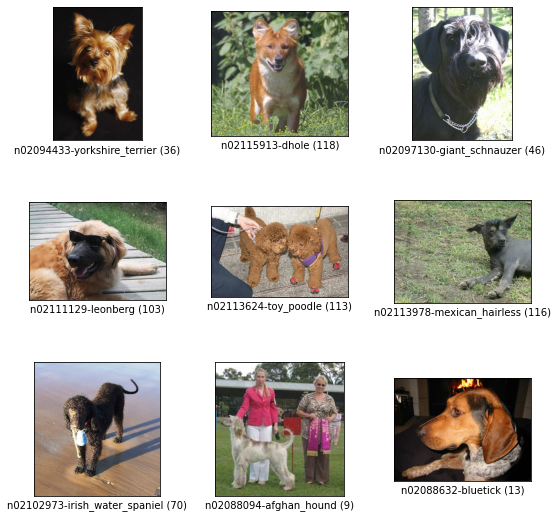

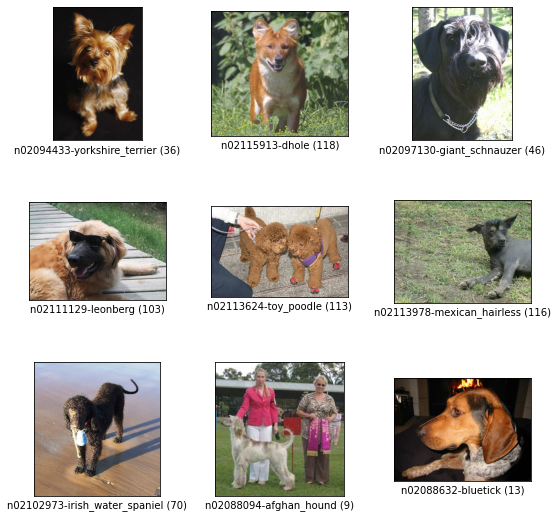

In [4]:
tfds.show_examples(ds_train, ds_info)

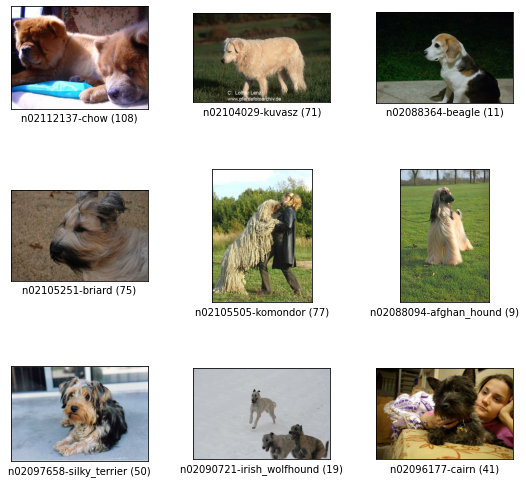

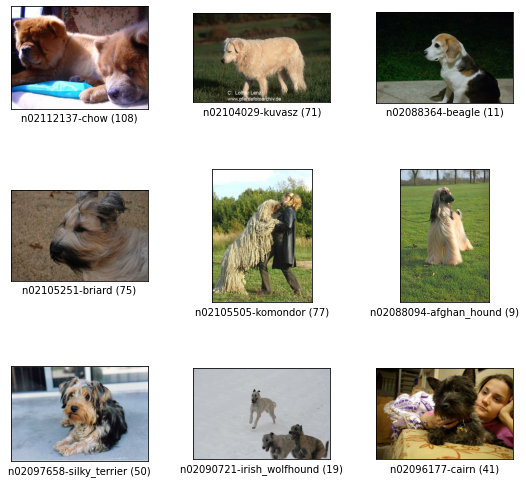

In [5]:
tfds.show_examples(ds_test, ds_info)

## 6.2) 물체의 위치정보

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 6.3) CAM을 위한 모델 만들기

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## 6.4) CAM 모델 학습하기


In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 172s 205ms/step - loss: 2.1882 - accuracy: 0.4502 - val_loss: 3.4029 - val_accuracy: 0.2035
Epoch 2/2
750/750 [==============================] - 157s 209ms/step - loss: 0.7836 - accuracy: 0.7838 - val_loss: 1.1031 - val_accuracy: 0.6801


#### 특정 모델 학습상태 저장하는 법

잘 기억해두자 외우긴 힘들고 이대로 따와서 써야할듯

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data'
cam_model.save(cam_model_path)

INFO:tensorflow:Assets written to: /root/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data/assets


INFO:tensorflow:Assets written to: /root/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data/assets


## 6.5) CAM


In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


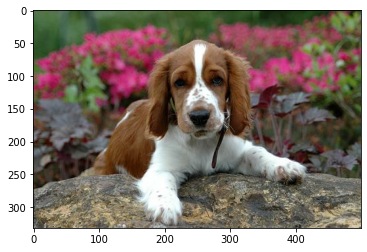

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [17]:
cam_model_path = os.getenv('HOME')+'/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data'
cam_model = tf.keras.models.load_model(cam_model_path)

### CAM 함수 
인수 : (model, item) -> 모델에 직접 적용하는듯.
두 번째 인수인 item이 뭘 의미 하는지 몰라도 일단 item변수선언해서 받아둠

모델 중 [-3] <- 인덱스를 통해서 뒤에서 3번째 레이어를 끊어서 가지고 온뒤

이미지와 예측값을 받아온 결과를 토대로

각 이미지에 대한 가중치를 역산?

가중치들로부터 Activation map를 구하는 것 같다.


In [19]:
import copy

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

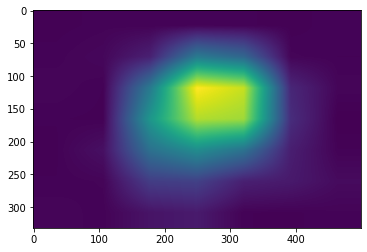

In [20]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

### 두 사진 혼합 함수
cv2.addWeighted(사진1, 가중치(alpha), 사진2, 가중치(beta), 가중치(gamma))

사진1과 alpha의 곱, 사진2와 beta의 곱에 gamma를 더한 값을 출력

#### 참고
cv2.add(사진1, 사진2) : 두 그림의 덧셈

cv2.subtract(사진1, 사진2) : 두 그림의 뺄셈

cv2.absdiff(사진1, 사진2) : 두 그림의 차이


In [21]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

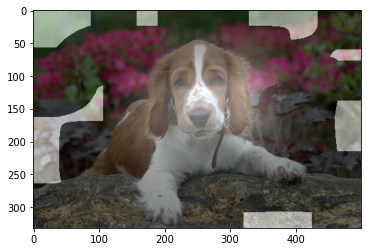

In [22]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 6.6) Grad-CAM

67


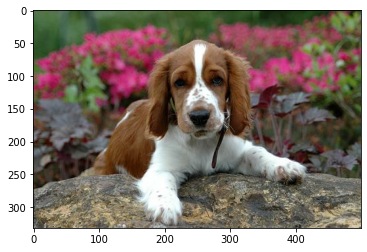

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### Grad-CAM 함수


### grad_cam 함수
엑티베이션 레이어를 직접 인덱스를 통해 찾아가는게 아니라

직접 인수로 받을 수 있다. (해당하는 레이어 미분값으로 직접찾기 가능이라 그런듯)

with 를 통해 라이브러리등의 표현을 호출하면, 사용 후 알아서 닫기 때문에

tape와 같은 기록형 라이브러리의 경우 별도 조치 없이 초기화를 할 수 있는 이유로

여기서 with를 사용한 것으로 보임

tf.GradientTape() :역전파에서 사용되는 자동 미분 매커니즘

정방향 연산의 순서를 tape에 기록해서 역방향 연산의 gradient를 구한다고 함



In [24]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

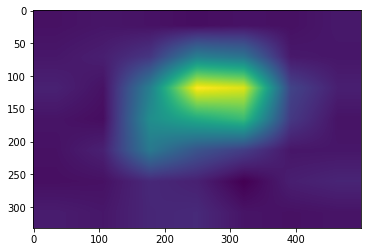

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

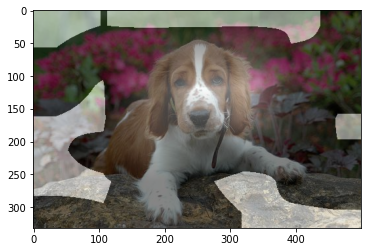

In [32]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

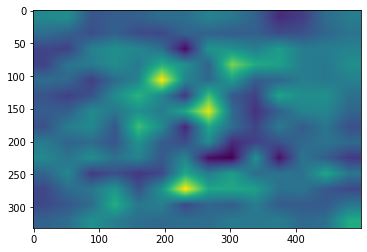

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

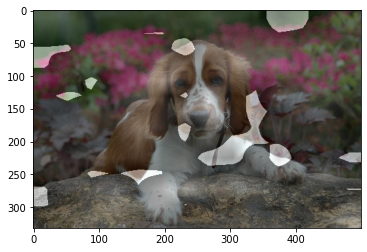

In [34]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

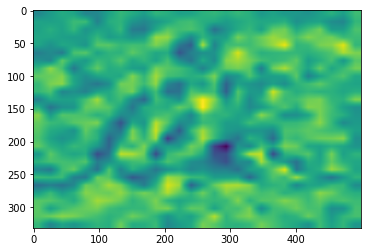

In [35]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

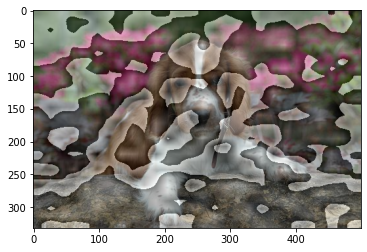

In [36]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 6.7) Detection with CAM

40


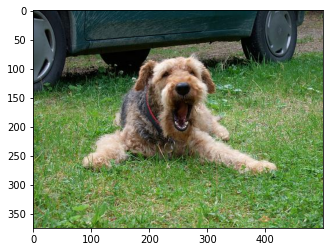

In [37]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

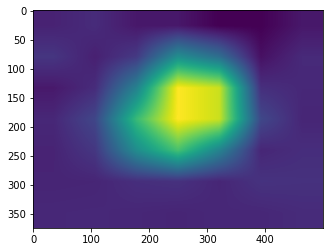

In [38]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

### box 만들기 함수
인수 이미지, score_thresh=   역치값에 해당

역치값이 너무 낮으면, 중요한 factor대신 노이즈에도 반응하므로 적절한 값을 찾아야 한다.

cv2.findContours(image, mode, method)

- 모드 =  cv2.RETR_로 시작하는 상수

 (1) EXTERNAL : 계층 정보 x, 바깥 외곽선만 검출합니다. 단순히 리스트로 묶어줍니다.

 (2) LIST : 계층 정보 x, 모든 외곽선을 검출합니다.(바깥, 안쪽), 순서는 랜덤입니다.

 (3) CCOMP : 계층 구조를 만들긴 하지만 2층 까지만 표현합니다. 2층이 넘어가면 1층으로 부여합니다.

 (4) TREE : 계층 구조를 만듭니다. 

- 메소드 =  cv2.CHAIN_APPROX_로 시작하는 상수

 외각선을 어떻게 그릴것인가 하는 것 : 주로 그냥 SIMPLE을 쓴다고함


여기서는 단순히 표준화된 이미지 픽셀들이 특정값 이하일때 box를 쳐주는 방식으로 접근한 것 같다.


In [47]:
def get_bbox(cam_image, score_thresh=0.15):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [48]:
rect = get_bbox(cam_image)
rect

array([[125, 302],
       [ 94,  68],
       [369,  31],
       [401, 266]])

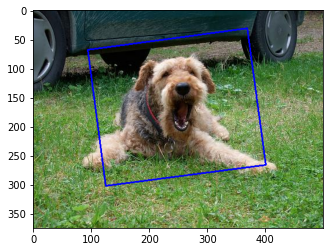

In [49]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [50]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [51]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.08266666666666667, 0.188, 0.8053333333333333, 0.802]

In [52]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

### IoU(Intersection over Union)

object detection에서 사용되는 도구 

객체 인식에서 모델 성능평가에 사용된다.

2개의 사각형이 얼마나 겹치는가를 측정한다고 이해하면 될듯

2개의 박스가 있을때 교집합 / 합집합의 넓이로 구한다.

마찬가지로 적절한 threshold값을 정하는 것이 성능상승에 도움이된다.

In [53]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [54]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7334035558960424

# 여기서부터 실습
## 6.8) CAM을 만들고 평가해 보자

#### 6.8.1)라이브러리 버전 확인 및 로드, 데이터 준비

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir="/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data"
)

#### 6.8.2) CAM 구현하기

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
print(num_classes)

120


In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 105s 121ms/step - loss: 2.1905 - accuracy: 0.4471 - val_loss: 3.3425 - val_accuracy: 0.2054
Epoch 2/5
750/750 [==============================] - 88s 118ms/step - loss: 0.7012 - accuracy: 0.8106 - val_loss: 1.1073 - val_accuracy: 0.6744
Epoch 3/5
750/750 [==============================] - 88s 118ms/step - loss: 0.1997 - accuracy: 0.9621 - val_loss: 0.9571 - val_accuracy: 0.7156
Epoch 4/5
750/750 [==============================] - 88s 117ms/step - loss: 0.1028 - accuracy: 0.9887 - val_loss: 0.9714 - val_accuracy: 0.7228
Epoch 5/5
750/750 [==============================] - 88s 118ms/step - loss: 0.0611 - accuracy: 0.9933 - val_loss: 0.9576 - val_accuracy: 0.7323


In [13]:
import os

cam_model_path = os.getenv('HOME')+'/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data/cam_model2.h5'
cam_model.save(cam_model_path)

Resnet50모델 (FC레이어를 떼어놓은) 로딩과 학습/저장까지 완료

이제 CAM의 이론대로라면 해야할일은

(1) Activation Map 중에서 가장 최근의 뽑아낸 특성에 해당하는

conv5_block3_out (Activation)  (None, 7, 7, 2048)   0

블록의 가중치를 뽑아내서

(2) 입력데이터와 동일한 [224,224] 차원의 픽셀로 만든 뒤 히트맵으로 변환

(3) 원본 그림과 겹치게 해서 적절한지 확인하면 된다. 

In [15]:
# 로드용 중간 기점
import os
from keras.models import load_model
cam_model_path = os.getenv('HOME')+'/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data/cam_model2.h5'
cam_model = load_model(cam_model_path)

In [ ]:
cam_model_path = os.getenv('HOME')+'/content/drive/MyDrive/Colab Notebooks/아이펠/GoingDeeper/class_activation_map/data/cam_model2.h5'
cam_model = load_model(cam_model_path)

(0)일단 데이터 셋 중 하나를 뽑는 함수가 필요

tensorflow에서 .take()는 numpy와는 다르게 배치를 반복하는 것이므로 별도의 변환이 필요 as_numpy_iterator()


In [16]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [19]:
def get_one(ds):
    ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


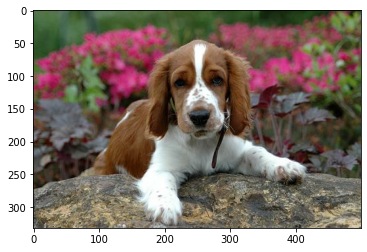

In [38]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [25]:
type(item) #타입은 dict 형태, 자바나 C/C++에서 사용할수 있도록 이렇게 해놓은 듯 하다. 익숙치 않다

dict

In [26]:
print(item)

{'image': array([[[230, 244, 245],
        [228, 242, 243],
        [226, 240, 241],
        ...,
        [227, 238, 242],
        [227, 238, 242],
        [228, 239, 243]],

       [[230, 244, 245],
        [228, 242, 243],
        [226, 240, 241],
        ...,
        [221, 232, 236],
        [222, 233, 237],
        [222, 233, 237]],

       [[230, 244, 245],
        [228, 242, 243],
        [226, 240, 241],
        ...,
        [224, 235, 239],
        [224, 235, 239],
        [224, 235, 239]],

       ...,

       [[164, 166, 144],
        [167, 169, 147],
        [163, 165, 143],
        ...,
        [161, 162, 148],
        [161, 162, 148],
        [161, 162, 148]],

       [[165, 167, 145],
        [167, 169, 147],
        [162, 164, 142],
        ...,
        [162, 163, 149],
        [162, 163, 149],
        [162, 163, 149]],

       [[166, 168, 146],
        [167, 169, 147],
        [161, 163, 141],
        ...,
        [162, 163, 149],
        [162, 163, 149],
        [162, 

대충 표준화되지 않은 image 크기도 제각각이며 Nomalize도 되지 않았다.

그림은 3차원(RGB)의 행렬 픽셀곱 (높이 X 너비)

레이블은 120개의 스칼라값

bbox라는 objects를 가지는 파일이 되었다.


In [28]:
print(item['image'].shape)

(347, 500, 3)


#### 6.8.2) CAM 구현하기

In [41]:
def generate_cam(model, item):   # 인수로 모델과 위에서 정리한 image를 받아옴
    item = copy.deepcopy(item)   # item image는 중첩 리스트를 가지는 tensor이므로 deepcopy 매서드 사용
    width= item['image'].shape[1]    # 그림의 높이와 길이지정 (같은 크기의 CAM 히트맵을 만들어 주기 위함)
    height = item['image'].shape[0]  # 이 그림 예시에선 [347, 500]의 차원을 가진다.

    img_tensor, class_idx = normalize_and_resize_img(item) 
    """
    normalize_and_resize_img 함수를 거쳐 그림을 [224, 224]차원으로 바꾸고, 255로 값들을 나눠 Norm으로 만들어준다.
    또한 image와 label을 분리해준다.
    """
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    """
    tf.keras.Model(inputs, outputs)을 인수로 가지는데 여기서 outputs부분을
    [model.layers[-3].output, model.output]으로 나오게 변환시켰다.
    때문에 모델에서 [-3]인덱스를 가지는 'conv5_block3_out' 레이어의 아웃풋과
    모델 전체의 아웃풋을 가지는 리스트를 결과로 도출한다.
    """

    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) #각각 이 결과는 conv_outputs과 레이블에 할당
    """
    여기서 사용한 tf.expand_dims은 이미지 텐서에 axis=0 즉 첫번째 인덱스에 길이 1을 가지는 차원을 추가해준다.
    원래 차원은 3차원이므로 [1, x, y, z]를 element로 가지는 텐서가 된다.
    """
    conv_outputs = conv_outputs[0, :, :, :]  # 1대신 0으로 대체해줌 (무슨 뜻?)
    class_weights = model.layers[-1].get_weights()[0]
    """
    모델의 [-1] 인덱스, 즉 dense레이어의 가중치 벡터를 class_weights로 선언
    """

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    """
    cam_image를 conv_outputs의 [0, 행]의 모양을 가지는 shape 0벡터로 선언
    """
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
    """
    class weights변수에서 각 가중치와 class를 뽑아내서 각 픽셀별로
    가중치값과 class에 따른 activation map을 뽑아냄
    """
    cam_image /= np.max(cam_image)  # activation score를 normalize
    cam_image = cam_image.numpy()   # 넘파이 배열로 변환
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기[224,224]로 resize
    return cam_image

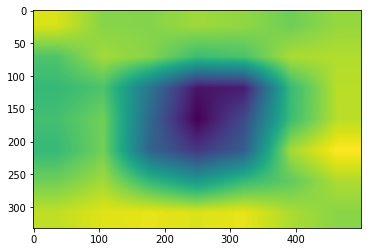

In [42]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

#### 6.8.3) visualize_cam_on_image() 함수 만들기

In [16]:
def visualize_cam_on_image(src1, src2, alpha=0.3):   # 인수로 그림 2개, 가중치는 합쳐서 1이므로 하나만 받음
    beta = (1.0 - alpha)                             # beta가 더 강조되도록 alpha 수치를 낮춰줌
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0) # addWeighted 매서드에 관한 설명은 상단에 정리함
    return merged_image

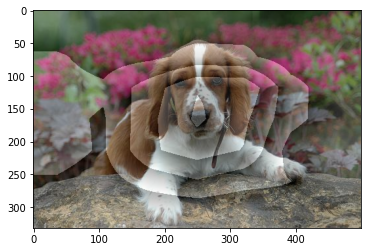

In [45]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8) #표준화 해줬기때문에 반대 과정을 거쳐서 차원을 맞춰줌

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

강아지의 코, 얼굴부분과 귀모양, 주둥이의 길이, 배경과의 비교(크기 가늠) 등이 개의 종 구별에 중요한 정보가 되므로

적절한 가중치를 통해 개의 종을 구분하고 있음을 볼 수 있었다.

#### 6.8.4) Grad-CAM 구현하기

80


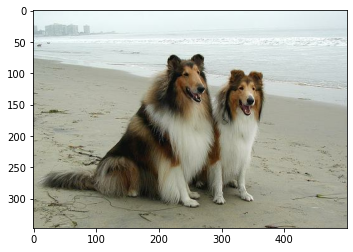

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [2]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)   # 여기까진 CAM과 동일

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    """
    CAM과 달리 Grad-CAM에서는 인수로 최종 Activation Map layer를 인수로 받기 때문에 
    output에 직접 선언한 변수를 대입 할 수 있다.
    """
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        """
        마찬가지로 axis=0에 '1' 값을 가지는 demention 추가(3차원 -> 4차원)
        gradient를 구해야하므로 tape를 통해 정방향 계산을 기록해둔다. 
        (computational graph를 통해 Backprop을 구하기 위해 사용되는 듯함)
        with는 앞서 확인했듯 매 사이클마다 초기화를 해주기 위함으로 보임
        """
        loss = pred[:, class_idx] # 정방향 함수 f=Wx+b 에서 함수의 결과는 loss에 해당하는 예측값
        output = conv_output[0] # 지정 layer를 통과했을때의 output 구하기
        grad_val = tape.gradient(loss, conv_output)[0] # 수식, 결과를 통해 gradient 구할 수 있는듯

    weights = np.mean(grad_val, axis=(0, 1)) # 가중치 구하기, 픽셀의 가로 세로의 평균치를 통해 가중치를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2]) # 가로세로 0 행렬로 초기화 후

    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
    """
    k = class_idx에 따른, 추출한 conv_output과 weight의 곱을 통해 Grad_CAM을 구함 
    """
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

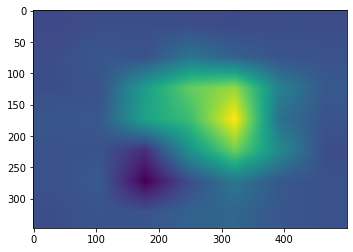

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

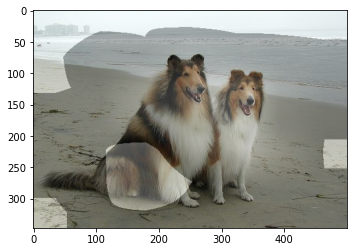

In [32]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

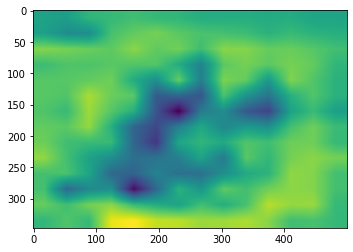

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

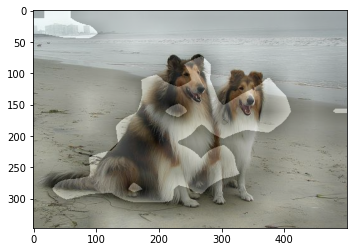

In [28]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

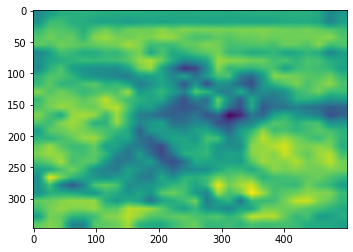

In [29]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

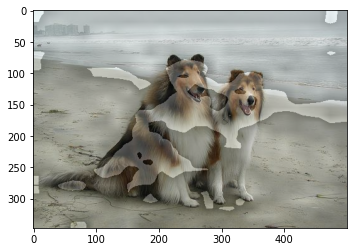

In [30]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

conv3 블록에서는 사진의 윤곽선 위주의 데이터를 체크하다가

conv4 블록에서는 좀더 추상적으로

conv5 블록까지 오니 강아지의 얼굴 위주로 가중치가 몰려있는 것을 확인 할 수 있었다.

신기하게도 컴퓨터는 인간의 휴리스틱 메커니즘까지 따라가는 것 같다.

#### 6.8.5) 바운딩 박스 구하기

In [45]:
def get_bbox(grad_cam_image, score_thresh=0.10):
    low_indicies = grad_cam_image <= score_thresh           #역치값 이하의 픽셀들을 low_indicies변수로 묶어주고
    grad_cam_image[low_indicies] = 0                        #이 픽셀들의 값은 전부 0으로 환원
    grad_cam_image = (grad_cam_image*255).astype(np.uint8)  #전체 픽셀에 255를 곱해 역Norm을 구해서
    
    contours,_ = cv2.findContours(grad_cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 사각형을 검출
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [46]:
rect = get_bbox(grad_cam_image)
rect

array([[311, 362],
       [ 88, 150],
       [272, -43],
       [495, 169]])

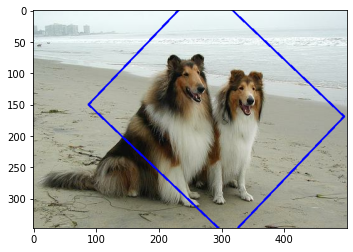

In [47]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### 6.8.6) IoU구하기

In [48]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [49]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.1239193083573487, 0.176, 1.043227665706052, 0.99]

In [50]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [51]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) 
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea) #교집합 / 합집합

    return iou

In [52]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.2686946745493528

In [53]:
rect = get_bbox(grad_cam_image, score_thresh=0.15)
rect

array([[362, 324],
       [105, 164],
       [215, -11],
       [472, 148]])

In [54]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.03170028818443804, 0.21, 0.9337175792507204, 0.944]

In [55]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3093599429967977

In [56]:
rect = get_bbox(grad_cam_image, score_thresh=0.25)
rect

array([[400, 273],
       [138, 252],
       [152,  72],
       [413,  92]])

In [57]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.207492795389049, 0.276, 0.7867435158501441, 0.826]

In [58]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3244083916983776

예상대로 역치값을 올리면 IoU가 오르는 현상을 확인했다.

아마 모델이나 epoch에 따라 상이하겠지만,

적절한 역치값을 찾는 것 또한 좋은 IoU를 구하는 방법인 거 같다.


#### 6.8.7) 회고

완전히 0에서 새로운 코드를 짜내는 것은 너무 어렵다.

아직 파이썬 실력이 많이 부족한 탓인것 같다.

어쩌다보니 정상적인 실습이아니라 예제를 2번 풀어보기만 한 것 같지만

나름대로 tensorflow의 reference를 찾아보면서 인수로 무엇을 받을지

또한 결과값이 어떻게 나오는지, 또 차원이 어떻게 변화하는지 체크해 볼 수 있어서

조금씩이나마 늘고 있다는 생각이 든다.

차원 추가 혹은 줄이는 부분에 있어서 이해가 잘 안되었던 부분도 체크해보아야 겠다.
